## Mackey-Glass equation - 1D example

The Mackey-Glass equation considers the population of mature blood cells, x(t), and models the process of the production of these cells. It has the following delay differential equation (DDE) system:

```math
\begin{align}
  \dot{x}&= \frac{\beta x(t-\tau)}{1+[x(t-\tau)]^n}- \gamma x(t)\\
\end{align}
```
where β expresses the dependence of blood cell production on the number of matrure cells already in the system; where γ is the death rate of mature cells and where τ is the delay between the production of blood cells in the bone marrow and the time taken to release these into the system (blood stream).

The following packages and functions are needed:

In [318]:
using CairoMakie
using LinearAlgebra
include("mackeyglassfunc.jl") #system of Mackey-Glass equation
include("mackeytau.jl") #Delay forumla for Mackey-Glass equation
include("../shared/f_deriv.jl") #used to find state and/or parameter derivatives
include("../shared/jacobian.jl") #Jacobian function
include("../shared/newton.jl") #Newton function
include("../shared/create_ststfunc.jl") #Initialisates a function to find equilibria 
include("../shared/track_curve.jl") #Tracking curve function (used for continuation and equilibria branches)
include("../shared/stab_func_matrix.jl") #uses large matrix method to find the stability and eigenvalues (and eigenvector and ω is interested in Hopf bifurcation)
include("../shared/create_hopffunc.jl") #finds initial guess for Hopf information and creates a function that can find the true Hopf values
include("../stab_func_DDE.jl")
include("../j_eval.jl")
include("../j_diff.jl")
#include("../shared/stab_func_DDE.jl")
#include("../shared/j_eval.jl")
#include("../shared/j_diff.jl")

j_diff (generic function with 1 method)

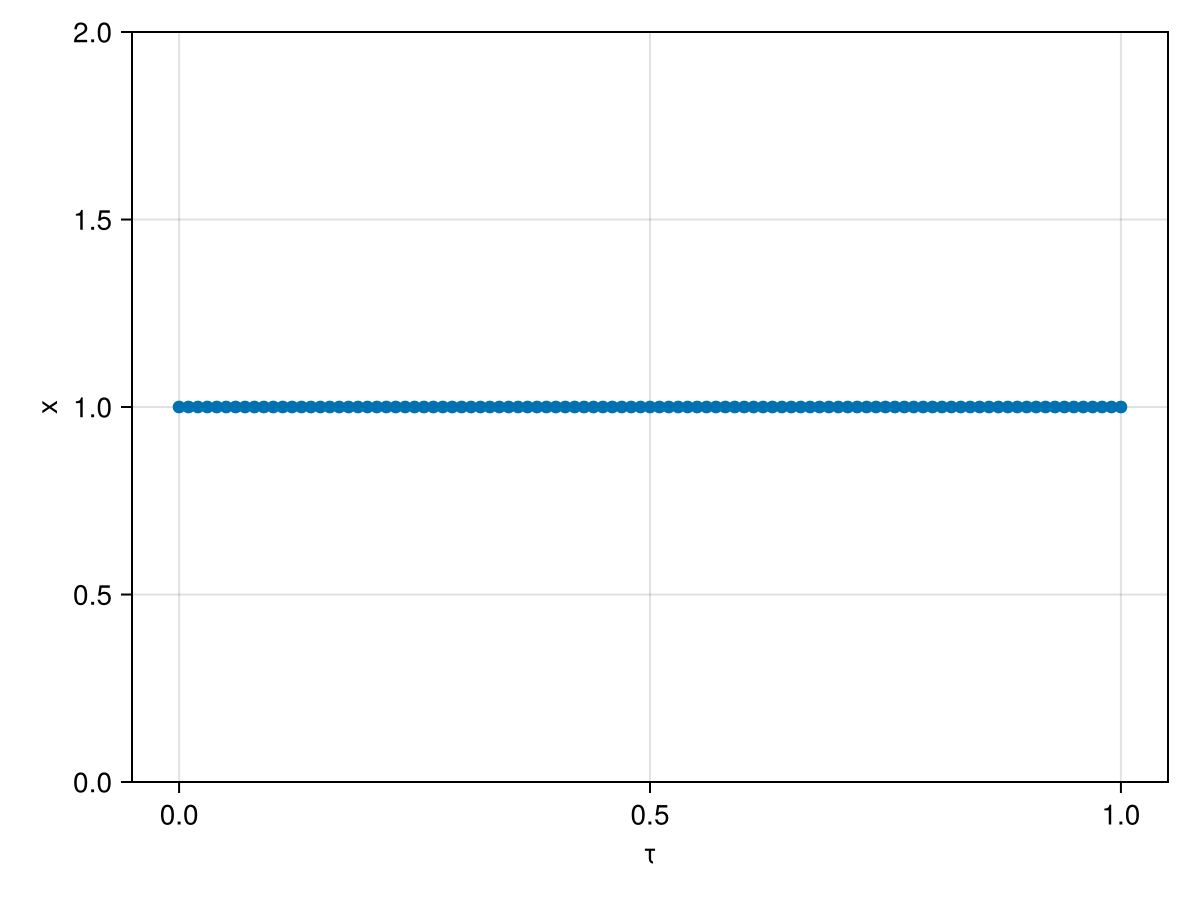

In [319]:
gamma=1.0
#initial states for following parameters (obtained from DDE-Biftool example)
beta=2 #try beta=3 for a change
n=10 #n=3 gives γ/β >=1-2/n so all of x should be stable (By Gupta source)
tau=0
x0=((beta-gamma)/(gamma))^(1/n) #obtained from solving f(x*,...,x*)=0 problem
nd=1 #one delay

y01,feq=create_ststfunc(mackeyglassfunc, x0, [beta,gamma,n,tau],nd, par_indx=4) #finds initial equilibrium point and creates a function to find the equilibria branch
ylist1,ytan1=track_curve(feq,y01,[0.0,1],stepsize=0.01,nmax=100) #tracks equilibria to find the equilibria branch

#Below plots the equilibiria branch
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="τ",ylabel="x")
scatter!(ax1,[u[2] for u in ylist1],[u[1] for u in ylist1])
lines!(ax1,[u[2] for u in ylist1],[u[1] for u in ylist1])
fig1

In [320]:
#check that f(x*,...x*,pars)=0
feq(y01)

1-element Vector{Float64}:
 0.0

# Stability

Finding the stability of equilibiria of DDEs is more complex than finding the stability of equilibria of ODEs due to the infinite dimensional past. For this example the stability was found by using a large matrix that can be used to create a finite-dimensional system that can approximate the stability of the equilibria. The function ``` stab_func_matrix ``` has a first output of 1 is the equilibrium point if stable and has 0 if it is unstable. Below we find the stability of one equilibrium point:

In [321]:
#stability of an equilibrium point
stab_func_matrix(mackeyglassfunc,mackeytau, [x0], [0.4],[gamma,beta,n,tau], [4], nd, doprint=1)

(1, ComplexF64[-486.6443159194877 + 0.0im, -486.183026118484 - 14.786984412212126im, -486.183026118484 + 14.786984412212126im, -484.80093909657637 - 29.516609950370288im, -484.80093909657637 + 29.516609950370288im, -482.5033950836206 - 44.13173934350338im, -482.5033950836206 + 44.13173934350338im, -479.2992714442893 - 58.57567766687368im, -479.2992714442893 + 58.57567766687368im, -475.2009482429123 - 72.79239136877224im  …  -16.96036821249696 - 63.1703274404643im, -16.96036821249696 + 63.1703274404643im, -12.830555667381233 - 48.573045787450724im, -12.830555667381233 + 48.573045787450724im, -9.371065016542675 - 33.71835565346033im, -9.371065016542675 + 33.71835565346033im, -6.2905194080540525 - 18.625248124910794im, -6.2905194080540525 + 18.625248124910794im, -1.7833392917706055 - 4.032566044790773im, -1.7833392917706055 + 4.032566044790773im], ComplexF64[0.0013307886027846038 + 0.0im 0.0013307594886547967 - 4.064149041508349e-5im … -0.0036048896431034867 - 0.06709548624977114im -0.003

We now find the stability for all the points on the equilibria branch, which are given in the vector ```stab```:

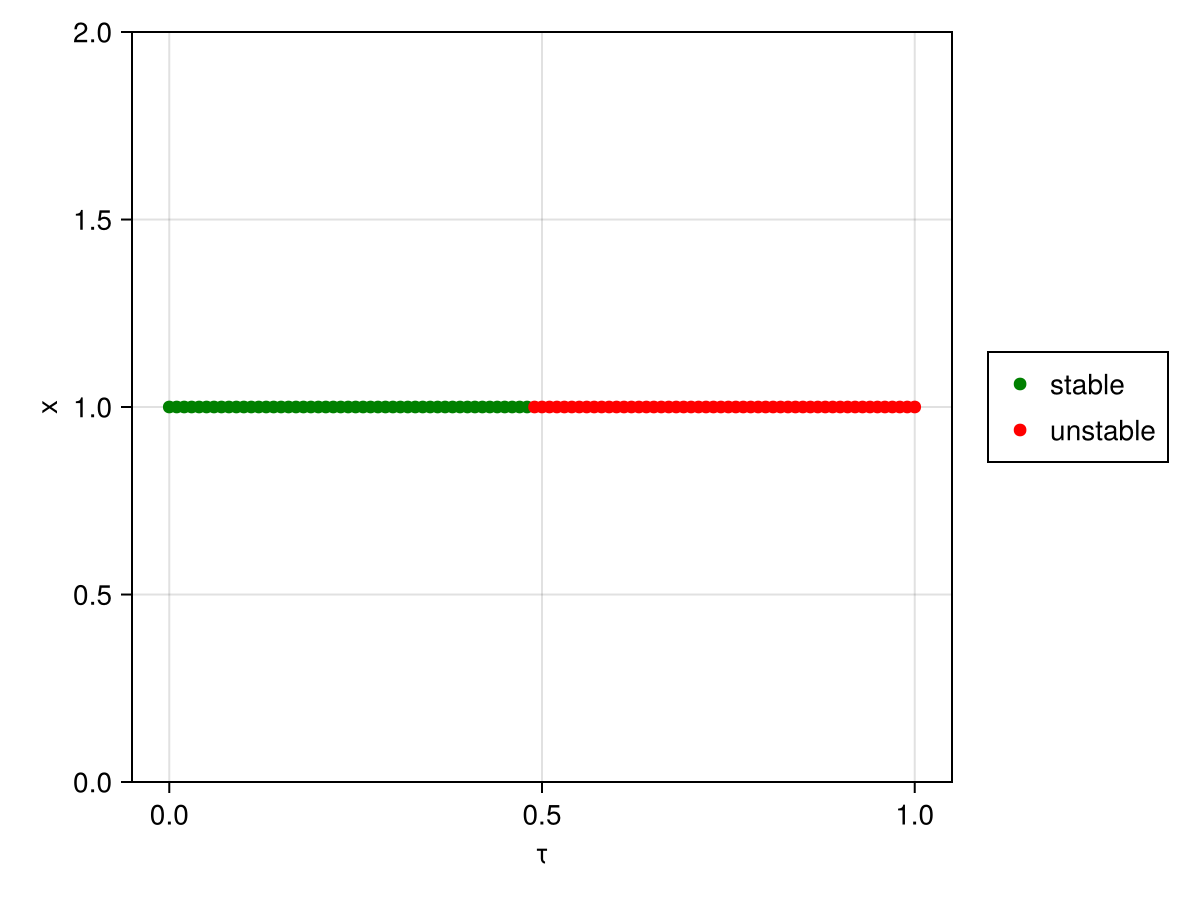

In [322]:
xmat1=hcat([u[1] for u in ylist1]) #finds values of equilibiria points (x)
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)] #turns values of equilibria points into vector of vectors

plist1=[u[2] for u in ylist1] #Delay value, τ, for each equilibrium point

m=100 #number of discretised steps
nx=1 #number of states 
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)

for i in 2:neq
    stab[i]=stab_func_matrix(mackeyglassfunc,mackeytau,xlist1[i],[plist1[i]],[beta, gamma,n,tau],[4],nd,doprint=0,m=m)[1] #returns stability of each equilibirum point (1=stable,0=unstable)
end

stab[1]=1.0 #NOTE THIS IS AN EDUCATED GUESS FOR NOW - Need to make my stability function work for it (currently have m/tau=m/0 in stability function for i=1)
stable=(stab.==1.0) #highlights stable indices
unstable=(stab.==0.0) #highlights unstable indices

#Below creates plot to show the stability of the equilibiria
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="τ",ylabel="x")
scatter!(ax2,plist1[stable],[u[1] for u in xlist1[stable]], color="green", label="stable")
scatter!(ax2,plist1[unstable],[u[1] for u in xlist1[unstable]], color="red", label="unstable")
Legend(fig2[1,2], ax2, merge=true)
fig2


# Stability using Breda et al (2009) method

The function ```stab_func_DDE``` uses the method described in (Breda et al 2009) to find the stability and the eigenvalues (and eigenvectors if asked) of an equilibrium point. For more information on this function, see the "Stability_finding_for_DDEs.ipynb" notebook. To do use ```stab_func_DDE```, the partial derivative matrices $A_0, A_1$ need to be found for x=1 (equilibrium point). These can be found manually (if  possible) or by using ```f_deriv```. In this example we'll use ```f_deriv``` to easily loop over all equilibrium points.

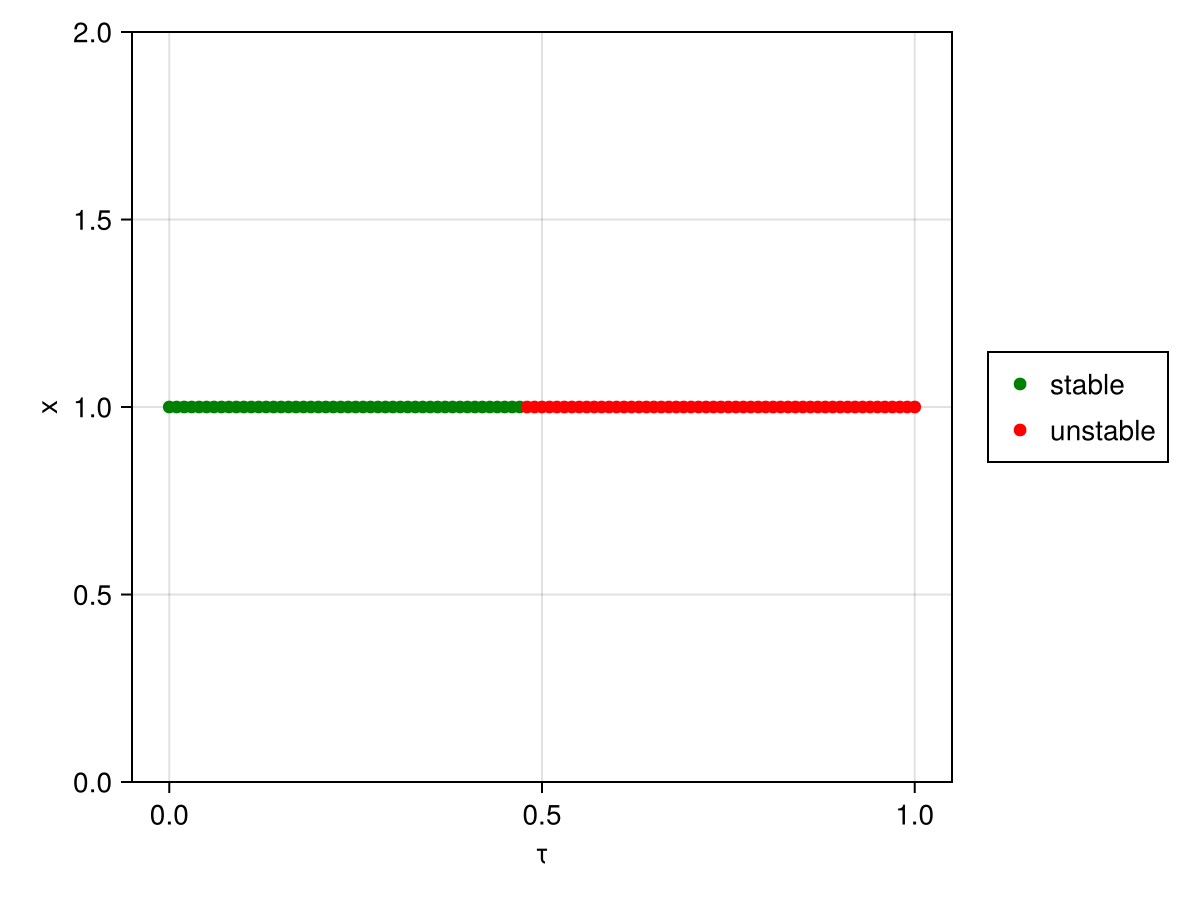

In [323]:
N=110 #so there are 151 interpolation points
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab_DDE=fill(NaN,neq)
#eigvals1=[fill(0.0+0.0*im,n*(1+nd*N)) for _ in 1:neq]
#lamr1=fill(0.0+0.0*im,neq)

#for i in 2:10
    #A0=f_deriv(mackeyglassfunc, xlist1[i],[beta, gamma,n,plist1[i]],nd,nx=1)
   # A1=f_deriv(mackeyglassfunc, xlist1[i],[beta, gamma,n,plist1[i]],nd,nx=2)
    #@infiltrate
    #stab_DDE[i],=stab_func_DDE([vec(A0),vec(A1)],[plist1[i]],10) ##note A0 and A1 need to be given in vector form as they are 1 dimensional
#end
#for i in 11:neq
    #A0=f_deriv(mackeyglassfunc, xlist1[i],[beta, gamma,n,plist1[i]],nd,nx=1)
    #A1=f_deriv(mackeyglassfunc, xlist1[i],[beta, gamma,n,plist1[i]],nd,nx=2)
    #@infiltrate
    #stab_DDE[i],=stab_func_DDE([vec(A0),vec(A1)],[plist1[i]],N)
#end
for i in 2:neq
    A0=f_deriv(mackeyglassfunc, xlist1[i],[beta, gamma,n,plist1[i]],nd,nx=1)
    A1=f_deriv(mackeyglassfunc, xlist1[i],[beta, gamma,n,plist1[i]],nd,nx=2)
    #@infiltrate
    stab_DDE[i],=stab_func_DDE([vec(A0),vec(A1)],[plist1[i]],N)
end

stab_DDE[1]=1.0
stableDDE=(stab_DDE.==1.0) #highlights indices of stable points (indicated by a 1 in stable vector)
unstableDDE=(stab_DDE.==0.0)#highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig5=Figure()
ax5=Axis(fig5[1,1],xlabel="τ",ylabel="x")
scatter!(ax5,plist1[stableDDE],[u[1] for u in xlist1[stableDDE]],label="stable",color="green")
scatter!(ax5,plist1[unstableDDE],[u[1] for u in xlist1[unstableDDE]],label="unstable",color="red")
Legend(fig5[1,2], ax5, merge=true)
fig5

# Hopf Bifurcation

The eigenvalues of the linearised system determine the equilibrium's stability. A Hopf bifurcation occurs when the stability behaviour changes and a pair of complex conugate eigenvalues of the linearised system crosses the imaginary axis and become purely imaginary, i.e. λ=±ωi. We start finding the Hopf parameters by finding the initial guess of the τ value for the Hopf bifurcation: 

First we'll find the delay $\tau$ for the Hopf bifurcation using the large matrix stability finding method (```stab_func_matrix```). The code for this is given below:

In [324]:
#Initial guess for tau for Hopf bifurcation using stab_func_matrix
hopf_indx=findfirst(isequal(0.0), stab) #finds index of initial parameter guess
p_hopf_est=plist1[hopf_indx] #initial guess for τ for Hopf bifurcation

0.49000000000000027

Having found the initial guess for the τ value of the Hopf bifurcation, we now find the ω value and true value of τ for the Hopf bifurcation:

In [325]:
yh01,fhopf=create_hopffunc(mackeyglassfunc,mackeytau,[beta,gamma,n,tau],xlist1[hopf_indx],[plist1[hopf_indx]],[4],nd) #outputs initial guess of the Hopf bifurcation (including x, ω and τ estimates) and a function that contians the method/formula to find the Hopf bifurcation
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=newton(fhopf,yh01) #putting initial guess and Hopf function into newton we get the true parameter values and information for the Hopf bifurcation
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
tau_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1]
println("The τ value for hopf bifurcation: $tau_hopf")
println("The ω value for hopf bifurcation: $om_hopf")

The initial guess for Hopf info: [1.0, -1.0, 0.0, 3.750387528138904, 0.49000000000000027]
The true information for the Hopf bifurcation: [1.0, -1.0, 0.0, 3.87298334183115, 0.47081962953876083]
converged?: true
The τ value for hopf bifurcation: 0.47081962953876083
The ω value for hopf bifurcation: 3.87298334183115


Next we'll find the delay $\tau$ for the Hopf bifurcation using the barycentric interpolation stability finding method (```stab_func_bi```). The code for this is given below:

In [326]:
#Initial guess for tau for Hopf bifurcation using stab_func_bi
hopf_biindx=findfirst(isequal(0.0), stab_bi) #finds index of initial parameter guess
p_hopf_biest=plist1[hopf_biindx] #initial guess for τ for Hopf bifurcation

UndefVarError: UndefVarError: `stab_bi` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [327]:
yh02,fhopf2=create_hopffunc(mackeyglassfunc,mackeytau,[beta,gamma,n,tau],xlist1[hopf_indx],[plist1[hopf_indx]],[4],nd,stabtype="bi",N_num=20) #outputs initial guess of the Hopf bifurcation (including x, ω and τ estimates) and a function that contians the method/formula to find the Hopf bifurcation
println("The initial guess for Hopf info: $yh02")
yh2,conv2,=newton(fhopf2,yh02) #putting initial guess and Hopf function into newton we get the true parameter values and information for the Hopf bifurcation
println("The true information for the Hopf bifurcation: $yh2")
println("converged?: $conv2")
tau_2hopf=yh2[end]
om_2hopf=yh2[end-1]
x_2hopf=yh2[1]
println("The τ value for hopf bifurcation: $tau_2hopf")
println("The ω value for hopf bifurcation: $om_2hopf")

UndefVarError: UndefVarError: `stab_func_bi` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [328]:
println("The estimated τ value for Hopf bifurcation using large matrix stability (stab_func_matrix) is: $p_hopf_est")
println("The estimated τ value for Hopf bifurcation using  barycentric interpolation stability (stab_func_bi) is: $p_hopf_biest")
println("The true τ value for hopf bifurcation when using stab_func_matrix: $tau_hopf")
println("The true τ value for hopf bifurcation when using stab_func_matrix: $tau_2hopf")

The estimated τ value for Hopf bifurcation using large matrix stability (stab_func_matrix) is: 0.49000000000000027


UndefVarError: UndefVarError: `p_hopf_biest` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

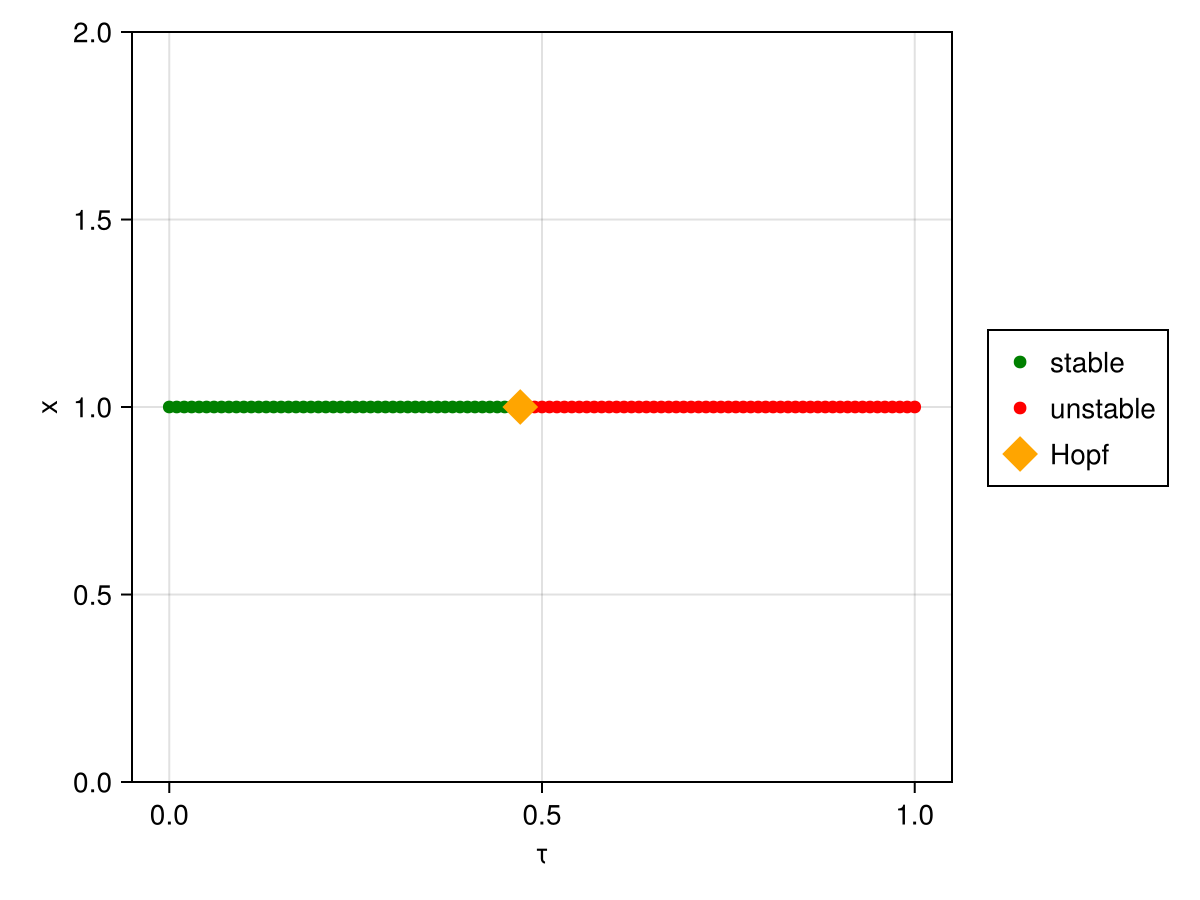

In [329]:
fig3=Figure()
ax3=Axis(fig3[1,1],xlabel="τ",ylabel="x")
scatter!(ax3,plist1[stable],[u[1] for u in xlist1[stable]], color="green", label="stable")
scatter!(ax3,plist1[unstable],[u[1] for u in xlist1[unstable]], color="red",label="unstable")
scatter!(ax3,tau_hopf,x_hopf,marker=:diamond,color=:orange,markersize=:20, label="Hopf")
Legend(fig3[1,2],ax3,merge=true)
fig3

# Continuation in (τ,β)-plane

We continue the Hopf points in the τ and β parameter plane:

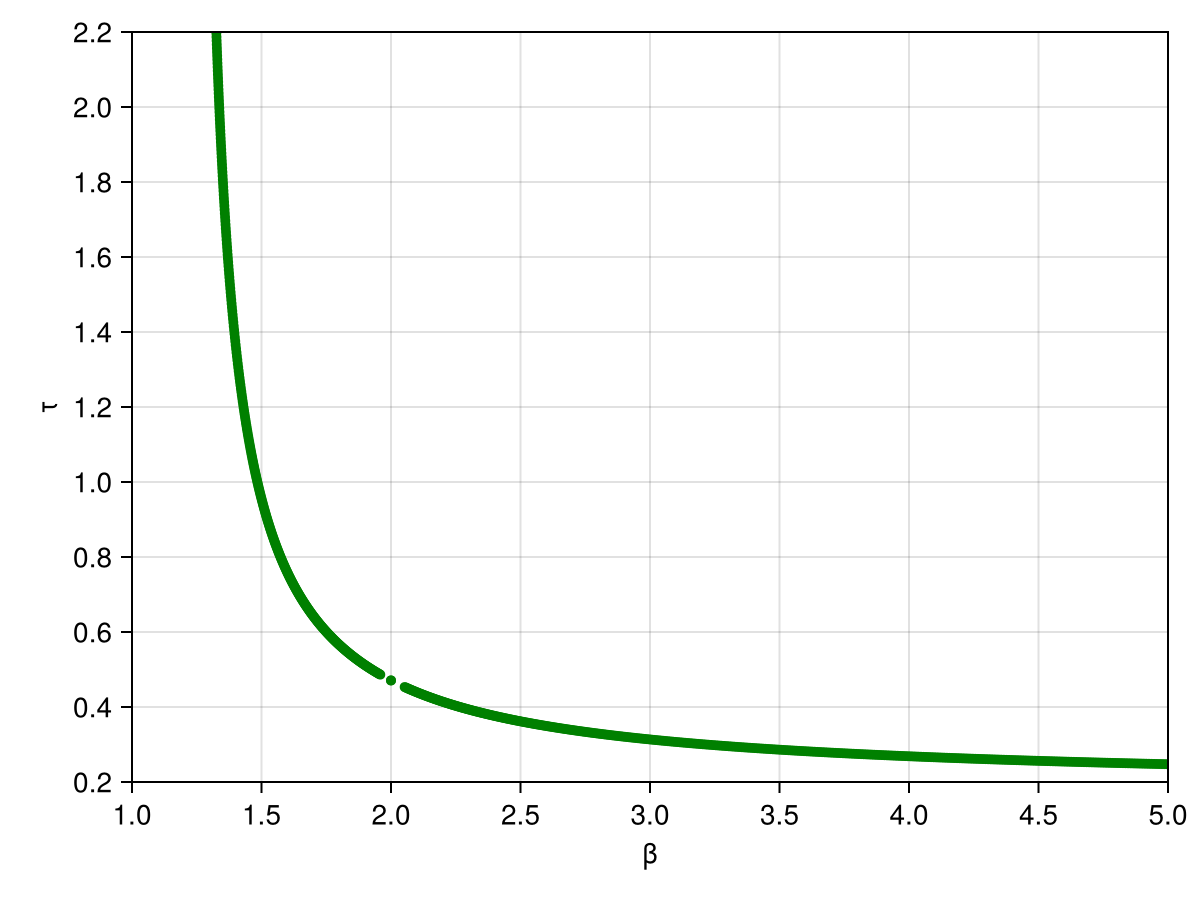

In [330]:
yheq01,fhopfeq1=create_hopffunc(mackeyglassfunc,mackeytau,[beta,gamma,n,tau_hopf],[x_hopf],[beta,tau_hopf],[1,4],nd)

yheqlist1,heqtan1=track_curve(fhopfeq1,yheq01,[-1.0,0,0,0,-1,-1],nmax=500) #tracks beta and tau backwards from beta=2, tau≈0.47 #chnage one to 1, -1
yheqlist2,heqtan2=track_curve(fhopfeq1,yheq01,[-1.0,0,0,0,1,1],nmax=500) #tracks beta and tau forwards from beta=2, tau≈0.47

#Plot of continuation/tracking in (a,b) plane
fig4=Figure()
ax4=Axis(fig4[1,1],xlabel="β",ylabel="τ")
scatter!(ax4,[u[end-1] for u in yheqlist1],[u[end] for u in yheqlist1],color="green",markersize=:7)
scatter!(ax4,[u[end-1] for u in yheqlist2],[u[end] for u in yheqlist2],color="green",markersize=:7)
ylims!(ax4,[0.2,2.2])
xlims!(ax4,[1,5])
ax4.xticks=1:0.5:5
ax4.yticks=0.2:0.2:2.2
fig4

# References

1. D. Breada, S. Maset, R. Vermiglio. *TACE-DDE: a Tool for Robust Analysis
and Characteristic Equations for Delay Differential Equations*, volume 388, pages 145-155, 2009